In [1]:
import os
import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
base_dir = '/content/drive/MyDrive/Colab Notebooks'
data_dir = os.path.join(base_dir,'EEG_SHCEEEZ-DL','out')
a_dataset = pathlib.Path(os.path.join(data_dir,'A'))

In [4]:
image_count = len(list(a_dataset.glob('*/*.png')))
print('number of total images:', image_count, '\n\n')

number of total images: 720 




In [6]:
batch_size = 128
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  a_dataset,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  a_dataset,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 720 files belonging to 2 classes.
Using 576 files for training.
Found 720 files belonging to 2 classes.
Using 144 files for validation.
['norm', 'sch']


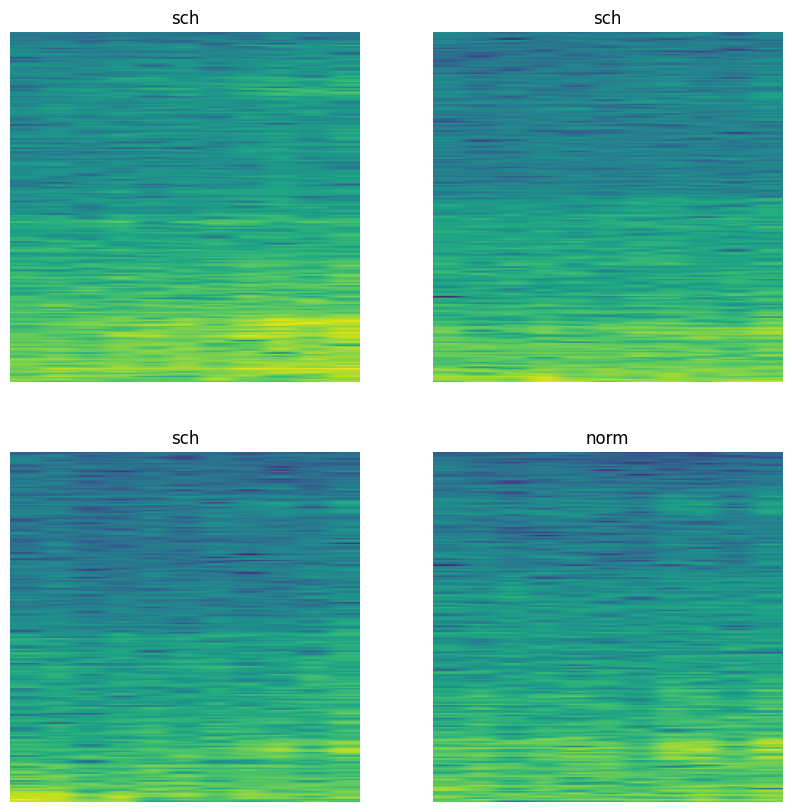

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

####**CNN classification with a simple model**

In [11]:
num_classes = len(class_names)

simple_model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.Conv2D(128, 3, activation='relu'),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.0001)
simple_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


simple_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=60)

Epoch 1/60
5/5 [==============================] - 70s 7s/step - loss: 0.6935 - accuracy: 0.4948 - val_loss: 0.6924 - val_accuracy: 0.5208
Epoch 2/60
5/5 [==============================] - 2s 340ms/step - loss: 0.6928 - accuracy: 0.5156 - val_loss: 0.6921 - val_accuracy: 0.5208
Epoch 3/60
5/5 [==============================] - 2s 343ms/step - loss: 0.6925 - accuracy: 0.5156 - val_loss: 0.6917 - val_accuracy: 0.5208
Epoch 4/60
5/5 [==============================] - 2s 350ms/step - loss: 0.6920 - accuracy: 0.5156 - val_loss: 0.6912 - val_accuracy: 0.5208
Epoch 5/60
5/5 [==============================] - 2s 346ms/step - loss: 0.6913 - accuracy: 0.5156 - val_loss: 0.6900 - val_accuracy: 0.5208
Epoch 6/60
5/5 [==============================] - 2s 349ms/step - loss: 0.6896 - accuracy: 0.5156 - val_loss: 0.6872 - val_accuracy: 0.5208
Epoch 7/60
5/5 [==============================] - 2s 352ms/step - loss: 0.6853 - accuracy: 0.5139 - val_loss: 0.6797 - val_accuracy: 0.6458
Epoch 8/60
5/5 [======

####**CNN classification with a VGG-16 model**

In [12]:
num_classes = len(class_names)

vgg16_model = keras.Sequential()
vgg16_model.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dense(4096,activation="relu"))
vgg16_model.add(layers.Dense(4096,activation="relu"))
vgg16_model.add(layers.Dense(num_classes, activation="softmax"))
vgg16_model.summary()

opt = keras.optimizers.Adam(learning_rate=0.0001)
vgg16_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

vgg16_model.fit(train_ds, validation_data=val_ds, epochs=60)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [13]:
models_path = os.path.join(base_dir, 'EEG_SHCEEEZ-DL', 'models')
vgg16_model.save(os.path.join(models_path, 'vgg16_model.h5'))
simple_model.save(os.path.join(models_path, 'simple_model.h5'))

use `model = keras.models.load_model('path/to/location')` to load the models

In [14]:
models_path = os.path.join(base_dir, 'EEG_SHCEEEZ-DL', 'models')
simple_model = keras.models.load_model(os.path.join(models_path, 'simple_model.h5')) 
vgg16_model = keras.models.load_model(os.path.join(models_path, 'vgg16_model.h5')) 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


In [ ]:
val_pred = vgg16_model.predict(val_ds)
val_true = np.concatenate([y for x, y in val_ds], axis=0)
val_pred = np.argmax(val_pred, axis=-1)


In [ ]:
cm = confusion_matrix(val_true, val_pred)


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


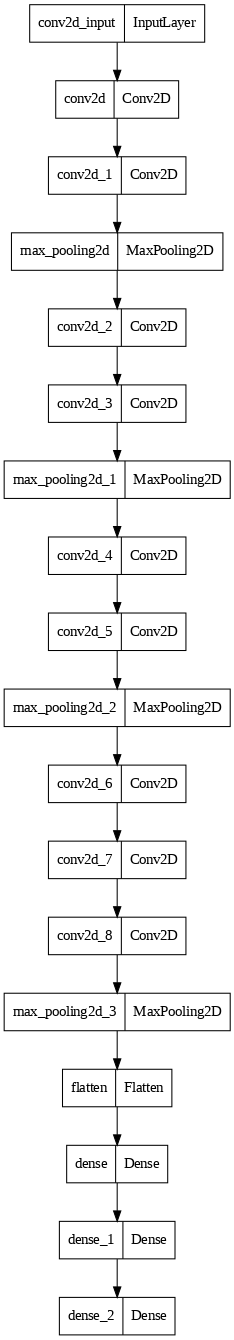

In [15]:
tf.keras.utils.plot_model(simple_model, dpi=75)

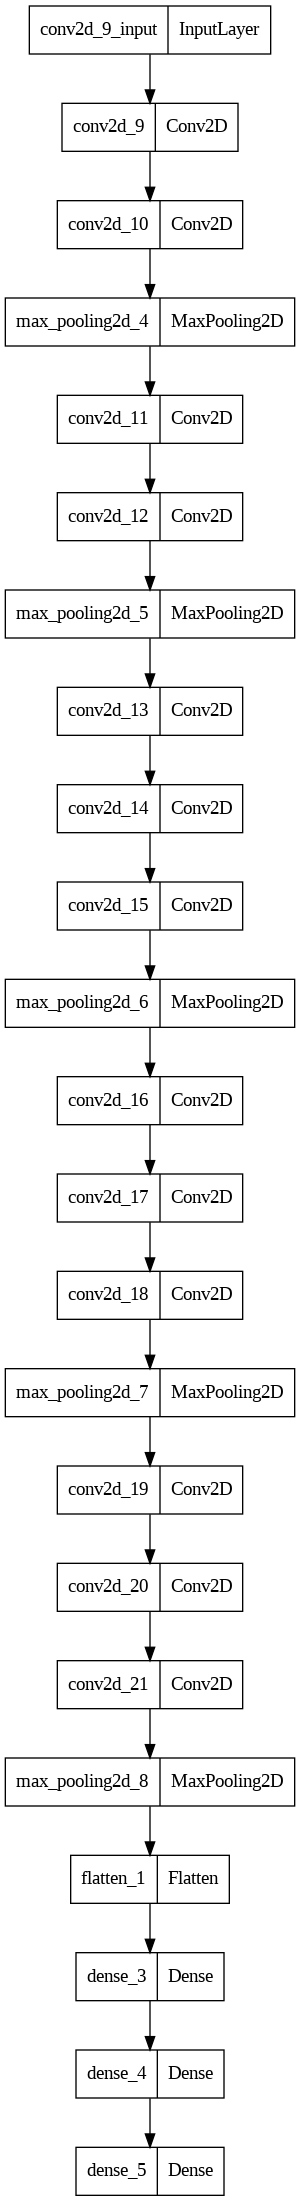

In [16]:
tf.keras.utils.plot_model(vgg16_model)

**Evaluations**

In [17]:
def evaluate(model, name='model'):
  loss, acc = model.evaluate(val_ds, batch_size= batch_size)
  print(f"{name}'s accuracy: {round((acc * 100), 2)}%")

evaluate(simple_model, 'simple CNN')
evaluate(vgg16_model, 'VGG-16')

2/2 [==============================] - 0s 26ms/step - loss: 0.2916 - accuracy: 0.9028
simple CNN's accuracy: 90.28%
2/2 [==============================] - 1s 73ms/step - loss: 0.4604 - accuracy: 0.9444
VGG-16's accuracy: 94.44%


In [18]:
def predict(model):
  return np.argmax(model.predict(val_ds), axis=-1)

def get_labels(dataset, batch_count=2):
  lst = []
  for im, label in val_ds.take(2):
    lst.extend(label.numpy())
  return np.array(lst)

vgg16_comparison_list = list(zip(predict(vgg16_model), get_labels(val_ds)))
simple_comparison_list = list(zip(predict(simple_model), get_labels(val_ds)))
print("VGG-16 (predictions, true labels): ", vgg16_comparison_list)
print("simple model (predictions, true labels): ", vgg16_comparison_list)

2/2 [==============================] - 0s 66ms/step
VGG-16 (predictions, true labels):  [(0, 0), (1, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (1, 1), (0, 1), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 1), (0, 0), (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (1, 0), (1, 1), (1, 1), (0, 1), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 1), (1, 1),